
Fold 1
0:	learn: 2296.7352945	test: 1922.6666654	best: 1922.6666654 (0)	total: 445ms	remaining: 11m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1922.666665
bestIteration = 0

Shrink model to first 1 iterations.
Validation MAE: 1922.67

Fold 2
0:	learn: 2090.2421878	test: 3566.9666657	best: 3566.9666657 (0)	total: 339ms	remaining: 8m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3508.094193
bestIteration = 37

Shrink model to first 38 iterations.
Validation MAE: 3508.09

Fold 3
0:	learn: 2531.2180855	test: 3949.7999996	best: 3949.7999996 (0)	total: 554ms	remaining: 13m 50s
200:	learn: 216.9838403	test: 2274.8006274	best: 2271.9588638 (194)	total: 5m 11s	remaining: 33m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2267.168498
bestIteration = 205

Shrink model to first 206 iterations.
Validation MAE: 2267.17

Fold 4
0:	learn: 2773.7500007	test: 9660.4666658	best: 9660.4666658 (0)	total: 343ms	remaining: 8m 33s
20

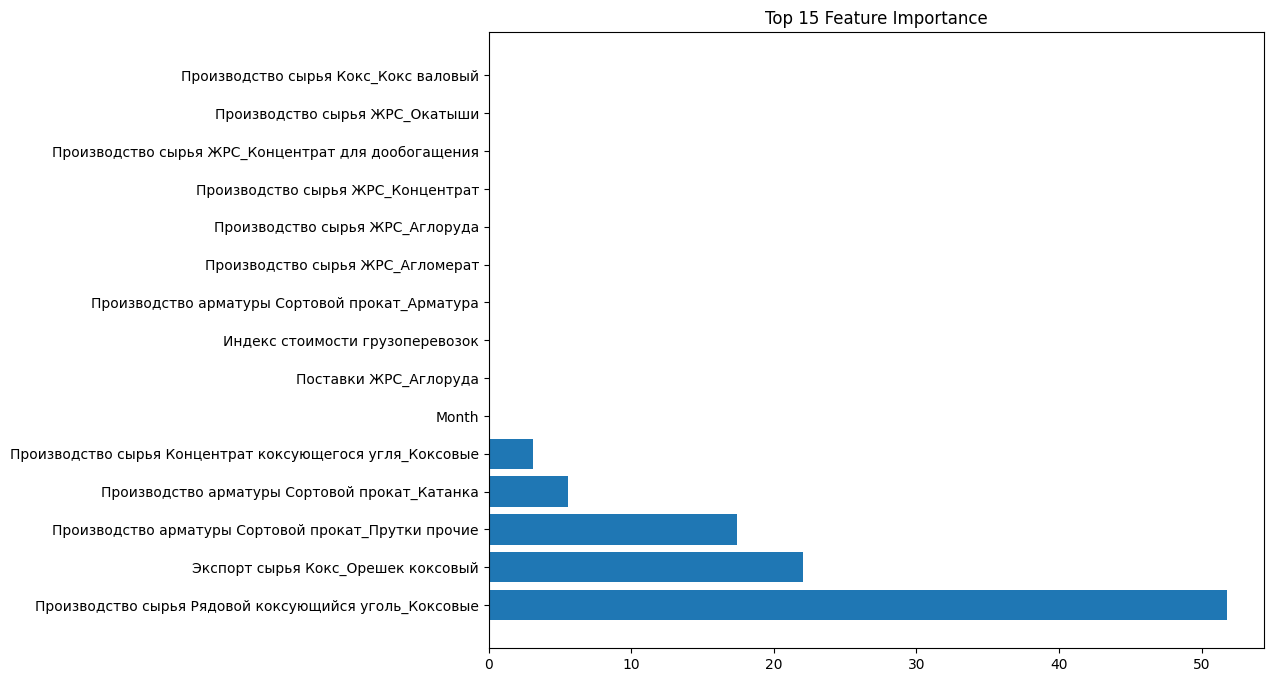

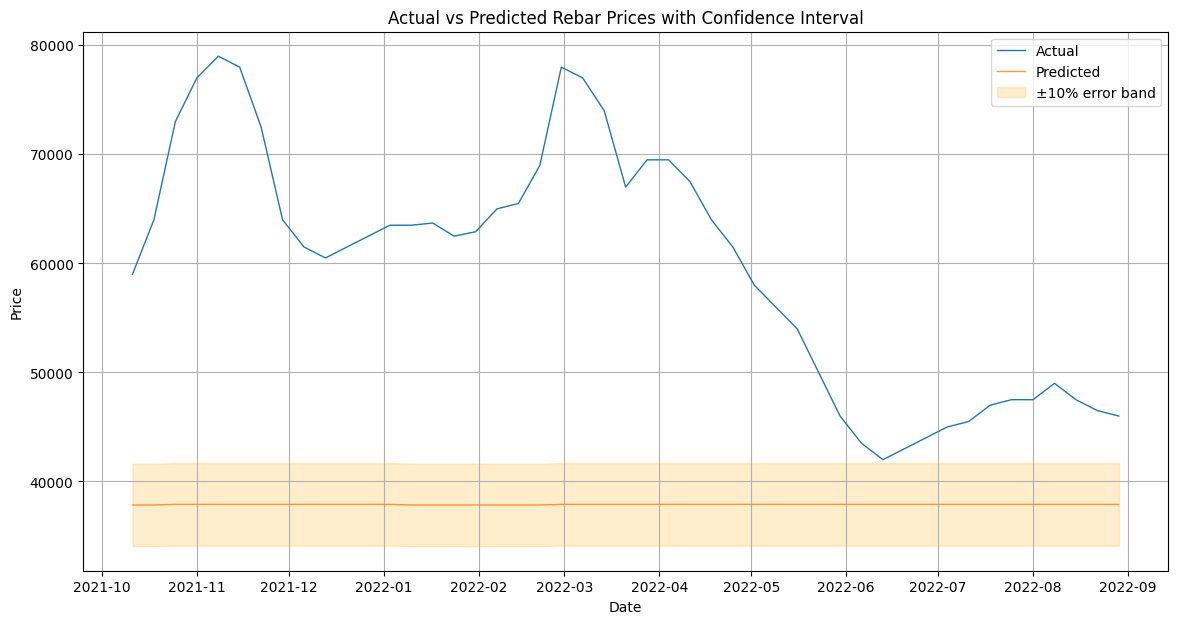

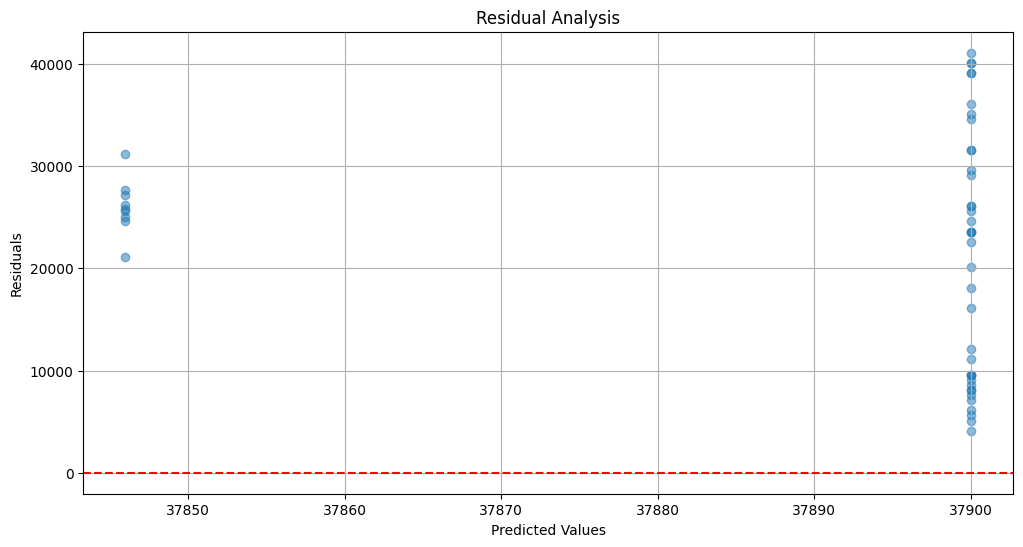

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Загрузка данных
data = pd.read_csv('cleaned_data.csv', parse_dates=['Date'], index_col='Date')

# Создание временных признаков
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Week'] = data.index.isocalendar().week
data['Day_of_year'] = data.index.dayofyear
data['Day_of_week'] = data.index.dayofweek
data['Quarter'] = data.index.quarter

# Добавление лаговых признаков (скользящие средние)
target = 'Цена на арматуру'
for window in [7, 14, 30]:
    data[f'rolling_mean_{window}'] = data[target].rolling(window=window).mean()
    data[f'rolling_std_{window}'] = data[target].rolling(window=window).std()

# Удаление строк с NaN (из-за скользящих статистик)
data = data.dropna()

# Разделение на признаки и целевую переменную
y = data[target]
X = data.drop(columns=[target])

# Масштабирование числовых признаков (кроме временных и категориальных)
numeric_features = X.select_dtypes(include=[np.number]).columns.difference(['Year', 'Month', 'Week', 'Day_of_year', 'Day_of_week', 'Quarter'])
scaler = RobustScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Разделение с учетом временного порядка
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Категориальные признаки
categorical_features = ['Year', 'Month', 'Week', 'Day_of_year', 'Day_of_week', 'Quarter']

# Оптимизированная модель CatBoost
model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    random_strength=0.5,
    loss_function='MAE',  # Используем MAE как более устойчивую метрику
    eval_metric='MAE',
    grow_policy='Lossguide',
    random_seed=42,
    cat_features=categorical_features,
    verbose=200,
    early_stopping_rounds=100
)

# Обучение с кросс-валидацией (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)
best_score = float('inf')
best_model = None

for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"\nFold {fold + 1}")
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(
        X_fold_train, y_fold_train,
        eval_set=(X_fold_val, y_fold_val),
        use_best_model=True,
        plot=False
    )
    
    val_pred = model.predict(X_fold_val)
    score = mean_absolute_error(y_fold_val, val_pred)
    print(f"Validation MAE: {score:.2f}")
    
    if score < best_score:
        best_score = score
        best_model = model.copy()

# Оценка на тестовых данных
test_pred = best_model.predict(X_test)
print("\nFinal Evaluation:")
print(f"Train MAE: {mean_absolute_error(y_train, best_model.predict(X_train)):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, test_pred):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, best_model.predict(X_train))):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.2f}")

# Визуализация важности признаков
feature_importance = best_model.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature Id'][:15], feature_importance['Importances'][:15])
plt.title('Top 15 Feature Importance')
plt.show()

# Визуализация прогнозов
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', linewidth=1)
plt.plot(y_test.index, test_pred, label='Predicted', alpha=0.8, linewidth=1)
plt.fill_between(y_test.index, 
                test_pred - 0.1*test_pred, 
                test_pred + 0.1*test_pred, 
                color='orange', alpha=0.2, label='±10% error band')
plt.title('Actual vs Predicted Rebar Prices with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Анализ остатков
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()